In [38]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LassoCV, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBClassifier
import xgboost as xgb
import optuna
from imblearn.over_sampling import SMOTE
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.downloader import load
import gensim.downloader as api
from sentence_transformers import SentenceTransformer
import torch
import torch.nn as nn
import torch.optim as optim

tqdm.pandas()


# 1. Data exploration and insights


In [ ]:
# Read all training files and concatenate them into one dataframe
li = []
for filename in os.listdir("train_tweets"):
    data = pd.read_csv("train_tweets/" + filename)
    li.append(data)
data = pd.concat(li, ignore_index=True)

print(data.head())

balance_classes = data['EventType'].value_counts()
print("Clasess balance :\n", balance_classes)

percentage_classes = (balance_classes / balance_classes.sum()) * 100
print("Percent per classes :\n", percentage_classes)

   Unnamed: 0    ID  MatchID  PeriodID  EventType      Timestamp  \
0           0  11_0       11         0          0  1404575400000   
1           1  11_0       11         0          0  1404575400000   
2           2  11_0       11         0          0  1404575400000   
3           3  11_0       11         0          0  1404575400000   
4           4  11_0       11         0          0  1404575400000   

                                               Tweet  
0  RT @2014WorIdCup: Argentina vs Belgium\n\nWho ...  
1  @elijahman_ time to focus on Belgium winning t...  
2  RT @FIFAWorldCup: GLOBAL STADIUM: #Joinin with...  
3  RT @CatholicNewsSvc: #PopeFrancis. Uh-oh. Arge...  
4  RT @soccerdotcom: If he scores vs #BEL we'll a...  
Clasess balance :
 EventType
1    2855069
0    2200981
Name: count, dtype: int64
Percent per classes :
 EventType
1    56.46837
0    43.53163
Name: count, dtype: float64


Wordcloud for EventType = 0


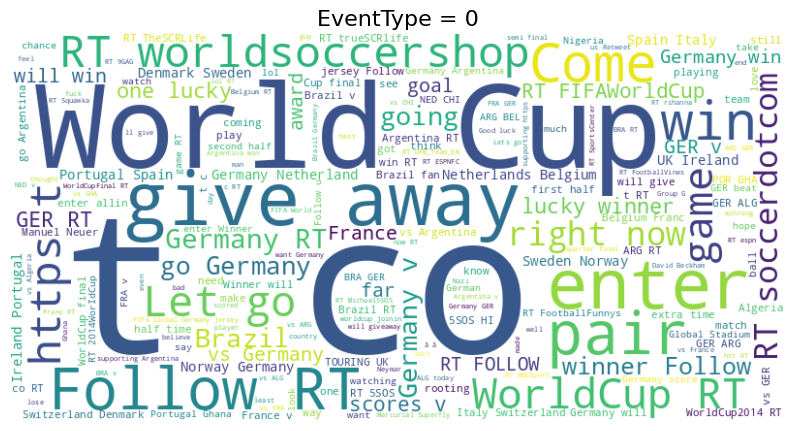

Wordcloud for EventType = 1


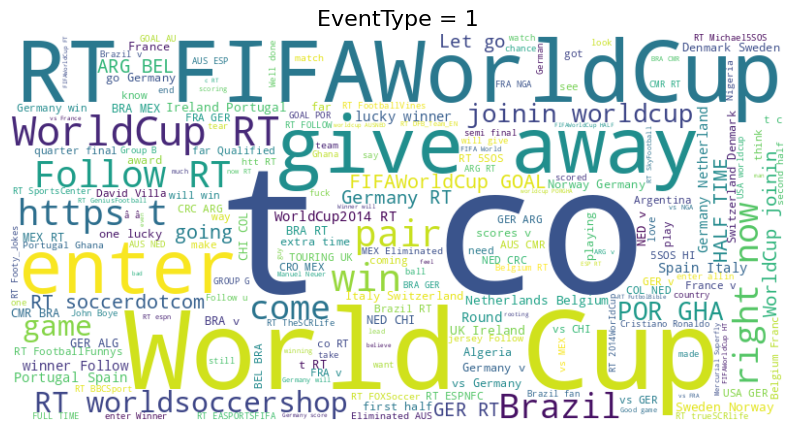

In [5]:
tweets_event_0 = " ".join(data[data['EventType'] == 0]['Tweet'].dropna())
tweets_event_1 = " ".join(data[data['EventType'] == 1]['Tweet'].dropna())

def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

print("Wordcloud for EventType = 0")
generate_wordcloud(tweets_event_0, "EventType = 0")

print("Wordcloud for EventType = 1")
generate_wordcloud(tweets_event_1, "EventType = 1")


The word clouds reveal that both classes predominantly contain phrases with similar words. This observation suggests that many of these terms may not be discriminative for classification purposes. Consequently, as part of the cleaning and preprocessing steps, we will first remove all spam tweets. Additionally, we will eliminate frequent words from the vocabulary that do not contribute meaningfully to class distinction. Retweets will also be excluded to further refine the dataset and reduce noise. Links and tags too.

# 1.1 Cleaning Dataset

In [16]:
def clean_tweets_dataset(data):
    """
    Cleans the dataset by removing spam tweets based on three criteria:
    1. Spam score > 1 using keywords: 'If', 'enter', pair', 'give', 'away', 'Follow', 'free'.
    2. More than 4 hashtags.
    3. Tweets containing 'RT'.
  
    """
        
    # Display the original length of the dataset
    print(f"Original dataset length: {len(data)}")
    
    # Spam keywords
    spam_keywords = ['If','enter', 'pair', 'give', 'away', 'Follow', 'free']
    
    # Calculate Spam Score
    data['Spam_Score'] = data['Tweet'].str.lower().apply(
        lambda x: sum(keyword.lower() in x for keyword in spam_keywords)
    )
    
    # Count hashtags
    data['Hashtags_Count'] = data['Tweet'].str.count(r'#')
    
    # Filtering
    data_cleaned = data[
        (data['Spam_Score'] <= 1) & 
        (data['Hashtags_Count'] <= 4) & 
        (~data['Tweet'].str.contains(r'\bRT\b', case=False))
    ]
    
    data_cleaned = data_cleaned.drop(columns=['Spam_Score', 'Hashtags_Count'], errors='ignore')
    
    print(f"Cleaned dataset length: {len(data_cleaned)}")
    
    return data_cleaned
 

data = clean_tweets_dataset(data)


Original dataset length: 5056050
Cleaned dataset length: 2312762


This cleaning step ensures that our dataset is more focused and less noisy

In [4]:
print(data.head())

balance_classes = data['EventType'].value_counts()
print("Classes balance :\n", balance_classes)

percentage_classes = (balance_classes / balance_classes.sum()) * 100
print("Percentage per classes :\n", percentage_classes)

   Unnamed: 0    ID  MatchID  PeriodID  EventType      Timestamp  \
1           1  11_0       11         0          0  1404575400000   
6           6  11_0       11         0          0  1404575400000   
7           7  11_0       11         0          0  1404575400000   
8           8  11_0       11         0          0  1404575400000   
9           9  11_0       11         0          0  1404575400000   

                                               Tweet  
1  @elijahman_ time to focus on Belgium winning t...  
6  I just hope Argentina lose. Would be fun to se...  
7  Watch Argentina vs Belgium 5th July 2014 LIVE ...  
8              @JRMun0z why dont you like Argentina.  
9  Even though I hate Belgium for beating the US,...  
Classes balance :
 EventType
1    1326075
0     986687
Name: count, dtype: int64
Percentage per classes :
 EventType
1    57.337288
0    42.662712
Name: count, dtype: float64


# 1.2 Data Preprocessing

In [17]:
def preprocess(dataframe):
    """
    Preprocesses tweets by performing:
    1. Lower casing 
    2. Punctuation removal
    3. Removal of stopwords, frequent, and rare words 
    4. Removal of emojis
    5. URL removal
    6. Removal of mentions (@tags)
    7. Lemmatization for Word Embeddings
    """

    def remove_emojis(text):
        emoji_pattern = re.compile(
            "["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
            u"\U00002700-\U000027BF"  # Dingbats
            u"\U000024C2-\U0001F251"  # Enclosed characters
            "]+",
            flags=re.UNICODE,
        )
        return emoji_pattern.sub(r"", text)

    def basic_cleaning(text):
        # Lowercasing
        text = text.lower()
        # Remove URLs
        text = re.sub(r"http\S+|www\S+|https\S+", '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove mentions (@tags)
        text = re.sub(r"@\w+", '', text)
        # Remove punctuation
        text = re.sub(r"[^\w\s]", '', text)
        # Remove emojis
        text = remove_emojis(text)

        words = text.split()
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word not in stop_words]
        return ' '.join(words)

    def lemmatize_text(text):
        lemmatizer = WordNetLemmatizer()
        words = text.split()
        words = [lemmatizer.lemmatize(word) for word in words]
        return ' '.join(words)

    dataframe['Tweet'] = dataframe['Tweet'].apply(basic_cleaning)

    dataframe['Lemmatized_Tweet'] = dataframe['Tweet'].apply(lemmatize_text)


    # Determine frequent and rare words
    cnt = Counter()
    for text in dataframe['Tweet'].values:
        for word in text.split():
            cnt[word] += 1

    frequent_threshold = 10  # Top 10 frequent words
    rare_threshold = 2  # Words that appear twice or less

    FREQWORDS = set([w for (w, wc) in cnt.most_common(frequent_threshold)])
    print(FREQWORDS)
    RAREWORDS = set([w for (w, wc) in cnt.items() if wc <= rare_threshold])
    print(RAREWORDS)

    def remove_unwanted_words(text):
        return " ".join([word for word in text.split() if word not in FREQWORDS and word not in RAREWORDS])

    dataframe['Tweet'] = dataframe['Tweet'].apply(remove_unwanted_words)
    dataframe['Lemmatized_Tweet'] = dataframe['Lemmatized_Tweet'].apply(remove_unwanted_words)

    print("Preprocessing completed.")
    return dataframe

data = preprocess(data)
data.to_csv("final_dataset.csv", index=False)

{'go', 'worldcup', 'argentina', 'germany', 'win', 'france', 'algeria', 'game', 'brazil', 'ger'}
{'grrermany', 'teamrather', 'reshmas', 'stoplying', 'idiote', 'fantasyland', 'jazeeraworldcup', 'isan', 'strongman', 'trappistes', 'nexttimemessi', 'scaredyoo', 'mybloodclautteam', 'slovãšnia', 'dafuqrotfl_hating', 'rlukaku', 'wantt', 'germanylots', 'semiiiii', 'susieqs', 'monkhouses', 'tönight', 'bollockscome', 'ifyouknowhatimean', 'mykidsrock', 'ideasits', 'foundconsign', 'peoplen', 'abalice', 'wrigleyfield', 'sunmer', 'swuuuur', 'damaaaaammm', 'ricarla', 'nopeee', 'gangstasillas', 'qualifyy', 'diffenders', 'effortbest', 'rensen', 'nascarfan', 'ibelieveinyoumessi', 'thisgameistoolong', 'tkole', 'princewc', 'kedavras', 'faand', 'cheelay', 'nopenopenope', 'combinationfrance', 'itaintronaldosfault', 'restmeanwhile', 'ranberto', 'consecrative', 'gggggooooooooalllllllllll', 'deebd', 'fantasyfootballb', 'riseoftheunderdogs', 'soilyes', 'reasonwhyicantwatchsoccer', 'fellainilongballs', 'orndorff'

### Final cleaned and preprocessed dataset

In [7]:
print(data.head())

balance_classes = data['EventType'].value_counts()
print("Classes balance :\n", balance_classes)

percentage_classes = (balance_classes / balance_classes.sum()) * 100
print("Percentage per classes :\n", percentage_classes)

   Unnamed: 0    ID  MatchID  PeriodID  EventType      Timestamp  \
1           1  11_0       11         0          0  1404575400000   
6           6  11_0       11         0          0  1404575400000   
7           7  11_0       11         0          0  1404575400000   
8           8  11_0       11         0          0  1404575400000   
9           9  11_0       11         0          0  1404575400000   

                                               Tweet  \
1               time focus belgium winning world cup   
6  hope lose would fun see belgium forward much w...   
7                 watch vs belgium th july live link   
8                                          dont like   
9  even though hate belgium beating us waffles da...   

                                    Lemmatized_Tweet  
1               time focus belgium winning world cup  
6  hope lose would fun see belgium forward much w...  
7                  watch v belgium th july live link  
8                                 

The final dataset classes are imbalanced, this will be taken into account later during the training phase.

### Distribution of events by period

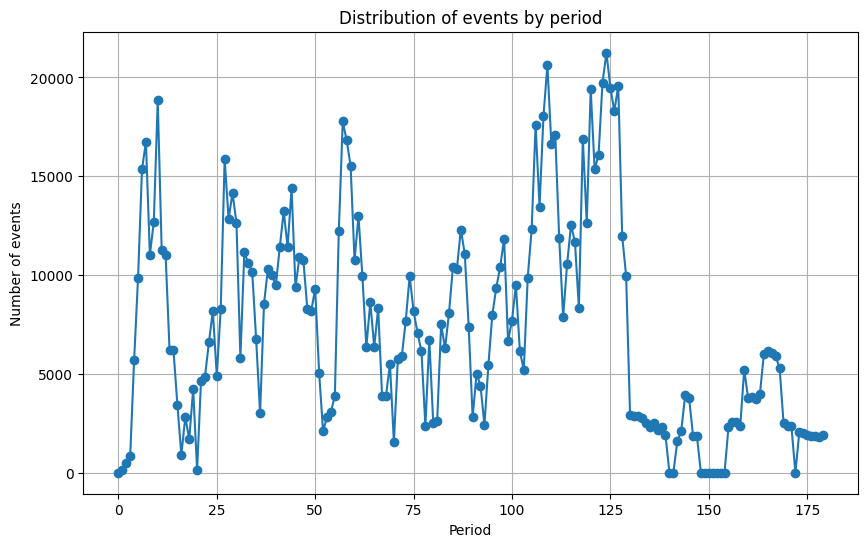

In [12]:
event_distribution = data.groupby('PeriodID')['EventType'].sum()


plt.figure(figsize=(10, 6))
plt.plot(event_distribution.index, event_distribution.values, marker='o')
plt.title("Distribution of events by period")
plt.xlabel("Period")
plt.ylabel("Number of events")
plt.grid()
plt.show()


We observe based on this plot that in general there is a lower activity between period_id 0-10 and around period_id 150

# 2. Feature Extraction

## 2.1 Words Embeddings

As described in the report, we will first check the coverage of our vocabulary by GloVe

In [18]:
def check_coverage(vocab, embeddings_index):
    
    in_vocab = {}
    out_of_vocab = {}
    found_count = 0  # word occurrences found in embeddings
    oov_count = 0    # Count of word occurrences not found in embeddings

    for word in tqdm(vocab, desc="Checking vocabulary coverage"):
        if word in embeddings_index.key_to_index:
            in_vocab[word] = embeddings_index[word]
            found_count += vocab[word]
        else:
            out_of_vocab[word] = vocab[word]
            oov_count += vocab[word]

    vocab_coverage = len(in_vocab) / len(vocab) if vocab else 0
    text_coverage = found_count / (found_count + oov_count) if (found_count + oov_count) > 0 else 0

    sorted_oov = sorted(out_of_vocab.items(), key=operator.itemgetter(1), reverse=True)

    print(f"Found embeddings for {vocab_coverage:.2%} of vocabulary.")
    print(f"Found embeddings for {text_coverage:.2%} of all text.")

    return vocab_coverage, text_coverage, sorted_oov

corpus_vocabulary = Counter()
for tweet in data['Lemmatized_Tweet']:
    for word in tweet.split():
        corpus_vocabulary[word] += 1

#GloVe Twitter embeddings
print("Loading GloVe Twitter Embeddings...")
glove_twitter = load("glove-twitter-200")  

vocab_coverage, text_coverage, oov_words = check_coverage(corpus_vocabulary, glove_twitter)

print(f"Vocabulary Coverage: {vocab_coverage:.2%}")
print(f"Text Coverage: {text_coverage:.2%}")
print("Top 30 OOV Words:")
print(oov_words[:30]) 



Loading GloVe Twitter Embeddings...


Checking vocabulary coverage: 100%|██████████| 66453/66453 [00:00<00:00, 1219206.79it/s]

Found embeddings for 70.11% of vocabulary.
Found embeddings for 96.31% of all text.
Vocabulary Coverage: 70.11%
Text Coverage: 96.31%
Top 30 OOV Words:
[('worldcupfinal', 29307), ('gervsalg', 17810), ('fifaworldcup', 14595), ('brazilvsgermany', 13436), ('gervsarg', 12879), ('bravsger', 10088), ('geralg', 8845), ('argvsbel', 7981), ('fravsger', 7730), ('gerarg', 7106), ('frager', 6992), ('fravsnga', 6949), ('argbel', 6395), ('brager', 5525), ('portugalghana', 3212), ('ausned', 2988), ('porvsgha', 2896), ('ausvsned', 2879), ('worldscup', 2708), ('gervsfra', 2694), ('fansconnect', 2621), ('argvsger', 2520), ('younaldo', 2461), ('bbcworldcup', 2458), ('openhappiness', 2360), ('germanyvsalgeria', 2335), ('gerfra', 2078), ('footballwithcoke', 1988), ('germanyvsfrance', 1953), ('franig', 1811)]


We will then consider next an hybrid approach as there are oov words made of valuable subwords

In [19]:
print("Loading FastText embeddings...")
fasttext = load("fasttext-wiki-news-subwords-300")

def get_combined_embedding(word, glove, fasttext, fallback_vector):
    """
    Get the concatenated embedding for a word using GloVe and FastText:
    - Uses FastText if GloVe is not available but not the other way around
    - Replaces OOV words with the embedding of "something" (fallback vector)

    """
    glove_dim = glove.vector_size
    fasttext_dim = fasttext.vector_size

    glove_vector = glove[word] if word in glove.key_to_index else np.zeros(glove_dim)
    fasttext_vector = fasttext[word] if word in fasttext.key_to_index else np.zeros(fasttext_dim)

    if np.all(glove_vector == 0) and np.all(fasttext_vector == 0):
        return fallback_vector
    return np.concatenate([glove_vector, fasttext_vector])

fallback_vector = np.concatenate([glove_twitter["something"], fasttext["something"]])


data['Hybrid_Embeddings'] = data['Lemmatized_Tweet'].progress_apply(
    lambda tweet: np.mean(
        [get_combined_embedding(word, glove_twitter, fasttext, fallback_vector) for word in str(tweet).split()],
        axis=0
    ) if tweet and len(str(tweet).split()) > 0 else fallback_vector
)

print("Done!")


Loading FastText embeddings...


100%|██████████| 2312762/2312762 [02:14<00:00, 17209.35it/s]


Done!


## 2.2 Sentence Embeddings

In [ ]:
print("Loading Sentence Transformer model...")
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
model = model.to('cuda') 

def generate_embeddings(texts, batch_size=400):
    
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch = texts[i:i+batch_size]
        batch_embeddings = model.encode(batch, batch_size=batch_size, show_progress_bar=False, device='cuda')
        embeddings.extend(batch_embeddings)
    return embeddings

print("Generating tweet embeddings using Sentence Transformer...")
tweets = data['Tweet'].fillna("").astype(str).tolist()  
data['Tweet_Embeddings'] = generate_embeddings(tweets, batch_size=400)

print("Done!")


/Data/harold.ngoupeyou/cheese_challenge/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Sentence Transformer model...


2024-12-12 09:01:14.271034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733990474.304032  646038 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733990474.313743  646038 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 09:01:14.381512: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Generating tweet embeddings using Sentence Transformer...


Generating embeddings: 100%|██████████| 5782/5782 [03:07<00:00, 30.76it/s]

Done!


In [21]:
def prepare_period_features(data, task = 'train'):
    """
    Group tweets by their corresponding period and compute average embedding
    """
    

    def compute_mean_embedding(embeddings):
        
        valid_embeddings = [e for e in embeddings if isinstance(e, (list, np.ndarray))]
        if valid_embeddings:
            return np.mean(np.vstack(valid_embeddings), axis=0)
        else:
            return None 

    period_features = data.groupby(['MatchID', 'PeriodID', 'ID']).agg({
        'Tweet_Embeddings': compute_mean_embedding,
        'Hybrid_Embeddings': compute_mean_embedding,
        'EventType' : 'first'
         }).reset_index() if task == 'train' else data.groupby(['MatchID', 'PeriodID', 'ID']).agg({
        'Tweet_Embeddings': compute_mean_embedding,
        'Hybrid_Embeddings': compute_mean_embedding
         }).reset_index()

    return period_features

train_data = prepare_period_features(data)
class_distribution = train_data['EventType'].value_counts()

class_distribution


EventType
1    1153
0     984
Name: count, dtype: int64

In [22]:
train_data.head()


MatchID  PeriodID   ID                                   Tweet_Embeddings  \
0        0         0  0_0  [-0.01247745, 0.066668585, -0.047687825, -0.00...   
1        0         1  0_1  [-0.01955445, 0.062170096, -0.04338483, -0.016...   
2        0         2  0_2  [-0.017546859, 0.0622868, -0.044241946, -0.011...   
3        0         3  0_3  [-0.0071672513, 0.059507426, -0.038454697, -0....   
4        0         4  0_4  [-0.015666738, 0.06583552, -0.057024207, -0.00...   

                                   Hybrid_Embeddings  EventType  
0  [0.07922709230043821, 0.1941892613198401, 0.01...          0  
1  [0.09729411734490061, 0.18472750349898645, 0.0...          0  
2  [0.05928356190724104, 0.1839198396704144, 0.03...          0  
3  [0.07053976445855191, 0.17959495567864514, -0....          0  
4  [0.07437117887809495, 0.19505597564072888, -0....          0

## Features Experiments and feature selection

### XGBOOST

In [23]:
from xgboost import XGBClassifier
X_hybrid =np.vstack(train_data['Hybrid_Embeddings']) 
X_sentence = np.vstack(train_data['Tweet_Embeddings']) 
X_combined = np.hstack((X_hybrid, X_sentence)) 
y = train_data['EventType'].values

X_train_hybrid, X_test_hybrid, y_train, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42
)

X_train_sentence, X_test_sentence, _, _ = train_test_split(
    X_sentence, y, test_size=0.2, random_state=42
)

X_train_combined, X_test_combined, _, _ = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

xgb_hybrid = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_hybrid.fit(X_train_hybrid, y_train)
y_pred_hybrid = xgb_hybrid.predict(X_test_hybrid)
accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid)

xgb_sentence = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_sentence.fit(X_train_sentence, y_train)
y_pred_sentence = xgb_sentence.predict(X_test_sentence)
accuracy_sentence = accuracy_score(y_test, y_pred_sentence)

xgb_combined = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_combined.fit(X_train_combined, y_train)
y_pred_combined = xgb_combined.predict(X_test_combined)
accuracy_combined = accuracy_score(y_test, y_pred_combined)

print(f'Accuracy without feature selection (hybrid): {accuracy_hybrid}')
print(f'Accuracy without feature selection (sentence): {accuracy_sentence}')
print(f'Accuracy without feature selection (combined): {accuracy_combined}')


Accuracy without feature selection (hybrid): 0.7523364485981309
Accuracy without feature selection (sentence): 0.7920560747663551
Accuracy without feature selection (combined): 0.764018691588785


Now feature selection on X_sentence with PCA, feature importance and Hydrid method

In [ ]:

pca = PCA(n_components=0.95, random_state=42) 
X_train_pca = pca.fit_transform(X_train_sentence)
X_test_pca = pca.transform(X_test_sentence)

xgb_pca = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_pca.fit(X_train_pca, y_train)
y_pred_pca = xgb_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

importances = xgb_sentence.feature_importances_
indices = np.argsort(importances)[::-1]  

accuracies = []
feature_counts = list(range(10, X_train_sentence.shape[1], 10))
print("Looking for the optimal number of features...")
for top_k in feature_counts:
    selected_features = indices[:top_k]  # Select top-k features
    X_train_selected = X_train_sentence[:, selected_features]
    X_test_selected = X_test_sentence[:, selected_features]
    
    xgb_selected = XGBClassifier(eval_metric='logloss', random_state=42)
    xgb_selected.fit(X_train_selected, y_train)
    y_pred_selected = xgb_selected.predict(X_test_selected)
    accuracy_selected = accuracy_score(y_test, y_pred_selected)
    accuracies.append((top_k, accuracy_selected))  

optimal_features = max(accuracies, key=lambda x: x[1])
optimal_k = optimal_features[0]
optimal_accuracy = optimal_features[1]
print(f'The optimal number of features is {optimal_k}')
selected_features = indices[:optimal_k]

X_train_selected = X_train_sentence[:, selected_features]
X_test_selected = X_test_sentence[:, selected_features]

xgb_selected = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_selected.fit(X_train_selected, y_train)
y_pred_selected = xgb_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)

lasso = Lasso(alpha=0.0001, random_state=42)  
lasso.fit(X_train_sentence, y_train)

sfm_lasso = SelectFromModel(lasso, prefit=True)
selected_features_lasso = sfm_lasso.get_support()
print(f"Number of features selected by LASSO: {np.sum(selected_features_lasso)}")

X_train_lasso = sfm_lasso.transform(X_train_sentence)
X_test_lasso = sfm_lasso.transform(X_test_sentence)
xgb_lasso = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_lasso.fit(X_train_lasso, y_train)
y_pred_lasso = xgb_lasso.predict(X_test_lasso)
accuracy_lasso = accuracy_score(y_test, y_pred_lasso)

print(f'Accuracy after PCA: {accuracy_pca}')
print(f'Accuracy after feature importance selection: {accuracy_selected}')
print(f'Accuracy after Hybrid method: {accuracy_lasso}')


Looking for the optimal number of features...
The optimal number of features is 300
Number of features selected by LASSO: 55
Accuracy after PCA: 0.8014018691588785
Accuracy after feature importance selection: 0.8084112149532711
Accuracy after Hybrid method: 0.780373831775701


## Overview of Models Evaluated

####  Logistic regression

In [76]:
scaler = StandardScaler()
X_train_combined = scaler.fit_transform(X_train_combined)
X_test_combined = scaler.transform(X_test_combined)

log_reg_selector = SelectFromModel(LogisticRegression(penalty="l1", C=0.1, solver="liblinear", random_state=42))
log_reg_selector.fit(X_train_combined, y_train)

X_train_selected = log_reg_selector.transform(X_train_combined)
X_test_selected = log_reg_selector.transform(X_test_combined)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_selected, y_train)
y_pred_hybrid = log_reg.predict(X_test_selected)
accuracy_hybrid = accuracy_score(y_test, y_pred_hybrid)

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_combined)
X_test_pca = pca.transform(X_test_combined)

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_pca, y_train)
y_pred_pca = log_reg.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

print(f'Accuracy after Hybrid feature selection: {accuracy_hybrid}')
print(f'Accuracy after PCA : {accuracy_pca}')

Accuracy after Hybrid feature selection: 0.7663551401869159
Accuracy after PCA : 0.7126168224299065


#### Random Forest

In [ ]:

pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_hybrid)
X_test_pca = pca.transform(X_test_hybrid)

rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train)
y_pred_pca = rf_pca.predict(X_test_pca)
accuracy_pca = accuracy_score(y_test, y_pred_pca)

rf_combined = RandomForestClassifier(random_state=42)
rf_combined.fit(X_train_hybrid, y_train)
importances = rf_combined.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort by importance (descending)

top_k = int(len(indices) * 0.7)  # Retain top 70% features
selected_features = indices[:top_k]

X_train_selected = X_train_hybrid[:, selected_features]
X_test_selected = X_test_hybrid[:, selected_features]

rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)
y_pred_selected = rf_selected.predict(X_test_selected)
accuracy_selected = accuracy_score(y_test, y_pred_selected)

print(f'Accuracy after PCA: {accuracy_pca}')
print(f'Accuracy after feature importance selection: {accuracy_selected}')

Accuracy after PCA: 0.7686915887850467
Accuracy after feature importance selection: 0.780373831775701


#### Deep Neural Networks

In [85]:
class BinaryClassificationNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3):
        super(BinaryClassificationNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate) 
        self.fc2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x
    
def train_evaluate_dnn(X, y, input_size, hidden_size=128, epochs=10, batch_size=32, learning_rate=0.001, weight_decay=0.01):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1) 
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = BinaryClassificationNN(input_size, hidden_size)
    criterion = nn.BCELoss()  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            predicted = (outputs >= 0.5).float()  
            y_pred.extend(predicted.numpy())
            y_true.extend(batch_y.numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    return accuracy

accuracy_hybrid = train_evaluate_dnn(X_hybrid, y, input_size=X_hybrid.shape[1])
accuracy_sentence = train_evaluate_dnn(X_sentence, y, input_size=X_sentence.shape[1])
accuracy_combined = train_evaluate_dnn(X_combined, y, input_size=X_combined.shape[1])


print(f'Accuracy without feature selection (hybrid): {accuracy_hybrid}')
print(f'Accuracy without feature selection (sentence): {accuracy_sentence}')
print(f'Accuracy without feature selection (combined): {accuracy_combined}')

pca = PCA(n_components=0.95, random_state=42) 
X_pca = pca.fit_transform(X_combined)
accuracy_pca = train_evaluate_dnn(X_pca, y, input_size=X_pca.shape[1])

print(f'Accuracy with PCA: {accuracy_pca}')


Accuracy without feature selection (hybrid): 0.75
Accuracy without feature selection (sentence): 0.7429906542056075
Accuracy without feature selection (combined): 0.7476635514018691
Accuracy with PCA: 0.719626168224299


# Hyperparameter Tuning

In [ ]:

y = train_data['EventType'].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_combined)

def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.5, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.8, 1.5),
        'seed': 42,
    }

    dtrain = xgb.DMatrix(data=X_normalized, label=y)
    cv_results = xgb.cv(
        dtrain=dtrain,
        params=params,
        nfold=9,
        stratified=True,
        num_boost_round=500,
        early_stopping_rounds=5,
        metrics="auc",
        as_pandas=True,
        seed=42
    )

    mean_auc = cv_results['test-auc-mean'].iloc[-1]

    return mean_auc 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("The best hyperparameters are:", study.best_params)


[I 2024-12-12 09:05:50,744] A new study created in memory with name: no-name-e53c2b19-05b8-43a2-a3e4-88496032a12f
[I 2024-12-12 09:05:54,613] Trial 0 finished with value: 0.7980648362312406 and parameters: {'max_depth': 10, 'gamma': 1.4929686312660118, 'reg_alpha': 43.5036128391515, 'reg_lambda': 8.442246268248468, 'colsample_bytree': 0.6006200351035724, 'min_child_weight': 17, 'learning_rate': 0.13823334065669457, 'subsample': 0.8012856545126936, 'scale_pos_weight': 1.1082483423335576}. Best is trial 0 with value: 0.7980648362312406.
[I 2024-12-12 09:05:59,105] Trial 1 finished with value: 0.7955011340379113 and parameters: {'max_depth': 5, 'gamma': 2.471920869358361, 'reg_alpha': 30.34535872864128, 'reg_lambda': 0.6470724760607476, 'colsample_bytree': 0.820120072615554, 'min_child_weight': 20, 'learning_rate': 0.1077880119122473, 'subsample': 0.7328377728704264, 'scale_pos_weight': 0.8223437371237381}. Best is trial 0 with value: 0.7980648362312406.
[I 2024-12-12 09:06:06,336] Trial 

The best hyperparameters are: {'max_depth': 9, 'gamma': 0.2099193207417277, 'reg_alpha': 3.524345835920206, 'reg_lambda': 2.2078399251125833, 'colsample_bytree': 0.6605976404078331, 'min_child_weight': 7, 'learning_rate': 0.06973455163021822, 'subsample': 0.8293091198961031, 'scale_pos_weight': 1.4552834445503369}


Now training with the best hparams : 

[0]	validation_0-logloss:0.69507	validation_1-logloss:0.69283
[1]	validation_0-logloss:0.68126	validation_1-logloss:0.68433
[2]	validation_0-logloss:0.66879	validation_1-logloss:0.67320
[3]	validation_0-logloss:0.65560	validation_1-logloss:0.66309
[4]	validation_0-logloss:0.64452	validation_1-logloss:0.65621
[5]	validation_0-logloss:0.63346	validation_1-logloss:0.64630
[6]	validation_0-logloss:0.62300	validation_1-logloss:0.63886
[7]	validation_0-logloss:0.61298	validation_1-logloss:0.63132
[8]	validation_0-logloss:0.60430	validation_1-logloss:0.62377
[9]	validation_0-logloss:0.59603	validation_1-logloss:0.61943
[10]	validation_0-logloss:0.58817	validation_1-logloss:0.61533
[11]	validation_0-logloss:0.57989	validation_1-logloss:0.60861
[12]	validation_0-logloss:0.57127	validation_1-logloss:0.60262
[13]	validation_0-logloss:0.56387	validation_1-logloss:0.59829
[14]	validation_0-logloss:0.55656	validation_1-logloss:0.59251
[15]	validation_0-logloss:0.54954	validation_1-logloss:0.58736
[1

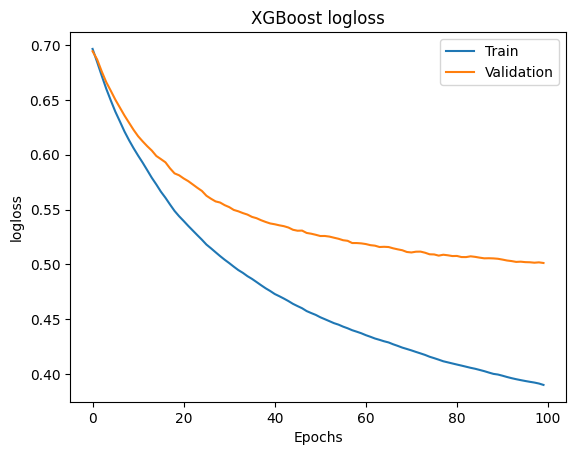

Best threshold : 0.53
Metrics with Selected Features:
Accuracy: 0.7819
ROC-AUC: 0.8433
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       156
           1       0.76      0.84      0.80       165

    accuracy                           0.78       321
   macro avg       0.79      0.78      0.78       321
weighted avg       0.78      0.78      0.78       321



In [ ]:

y = train_data['EventType'].values
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_combined)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.15, random_state=42)
smote = SMOTE(sampling_strategy={0: y_train.tolist().count(1)}, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

best_params = {'colsample_bytree': 0.8449516219682969, 'gamma': 1.2061801183928935, 'learning_rate': 0.057552365631329996, 'max_depth': 6, 'min_child_weight': 13.0, 'reg_alpha': 3.0, 'reg_lambda': 5.671012554391605, 'scale_pos_weight': 1.4608829410659183, 'subsample': 0.690035455077677}
#best_params = {'max_depth': 9, 'gamma': 0.2099193207417277, 'reg_alpha': 3.524345835920206, 'reg_lambda': 2.2078399251125833, 'colsample_bytree': 0.6605976404078331, 'min_child_weight': 7, 'learning_rate': 0.06973455163021822, 'subsample': 0.8293091198961031, 'scale_pos_weight': 1.4552834445503369}
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss', 
    **best_params,early_stopping_rounds=5,         
)

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_model.fit(
    X_train, y_train,
    eval_set=eval_set,
    verbose=True
)



import shap
explainer = shap.Explainer(xgb_model)
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_train)

shap_importance = np.abs(shap_values.values).mean(axis=0)
top_features_idx = np.argsort(shap_importance)[-25:]  #We found that 25 features yield a better score
X_train_top = X_train[:, top_features_idx]
X_test_top = X_test[:, top_features_idx]

eval_set = [(X_train_top, y_train), (X_test_top, y_test)]
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',  
    **best_params,early_stopping_rounds=5,        
)

xgb_model.fit(
    X_train_top, y_train,
    eval_set=eval_set,
    verbose=True
)

results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure()
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('logloss')
plt.title('XGBoost logloss')
plt.show()

y_pred_prob = xgb_model.predict_proba(X_test_top)[:, 1]
from sklearn.metrics import accuracy_score, f1_score

# find the best threshold as we conducted the tuning based on the auc
thresholds = np.arange(0, 1.01, 0.001)
best_threshold = 0.5
best_accuracy = 0
best_f1 = 0

for threshold in thresholds:
    y_pred = (y_pred_prob >= threshold).astype(int)  
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    if acc > best_accuracy:
        best_accuracy = acc
        best_threshold = threshold
        best_f1 = f1

print(f"Best threshold : {best_threshold:.2f}")

y_pred_binary = (y_pred_prob > best_threshold).astype(int)
print("Metrics with Selected Features:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_binary):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_binary))



# Final Model

In [127]:
smote = SMOTE(sampling_strategy={0: y.tolist().count(1)}, random_state=42)
X_normalized, y = smote.fit_resample(X_normalized, y)

best_params = {'colsample_bytree': 0.8449516219682969, 'gamma': 1.2061801183928935, 'learning_rate': 0.057552365631329996, 'max_depth': 6, 'min_child_weight': 13.0, 'reg_alpha': 3.0, 'reg_lambda': 5.671012554391605, 'scale_pos_weight': 1.4608829410659183, 'subsample': 0.690035455077677}

data_dmatrix = xgb.DMatrix(data=X_normalized[:, top_features_idx], label=y)

# Cross validation to find the optimal num_iterators

xgb_cv = xgb.cv(
    dtrain=data_dmatrix,         
    params=best_params,          
    nfold=9,                    
    num_boost_round=1000,        
    early_stopping_rounds=20,    
    metrics="logloss",  
    as_pandas=True,             
    seed=42                  
)

print(xgb_cv)

best_num_boost_rounds = xgb_cv.shape[0]
print(f"Nombre optimal de boosting rounds : {best_num_boost_rounds}")

# Training the final model 

final_model = xgb.train(
    params=best_params,       
    dtrain=data_dmatrix,     
    num_boost_round=best_num_boost_rounds, 
)


import joblib
model_filename = "final_xgb_model.pkl"
joblib.dump(final_model, model_filename)


     train-logloss-mean  train-logloss-std  test-logloss-mean  \
0              0.693309           0.000520           0.696832   
1              0.677270           0.001287           0.684035   
2              0.663080           0.001475           0.672719   
3              0.649747           0.001295           0.662144   
4              0.637494           0.001630           0.652339   
..                  ...                ...                ...   
229            0.430781           0.005640           0.507875   
230            0.430736           0.005646           0.507910   
231            0.430682           0.005717           0.507864   
232            0.430536           0.005663           0.507830   
233            0.430509           0.005703           0.507818   

     test-logloss-std  
0            0.012792  
1            0.012896  
2            0.012818  
3            0.012787  
4            0.013664  
..                ...  
229          0.031029  
230          0.031061  
231

['final_xgb_model.pkl']

# FINAL SUBMISSION

In [119]:
folder_path = "eval_tweets"

dataframes = []

for filename in os.listdir(folder_path):
    if filename.endswith(".csv"):  
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        dataframes.append(df)

sub = pd.concat(dataframes, ignore_index=True)
sub = clean_tweets_dataset(sub)
preprocess(sub)
sub['Hybrid_Embeddings'] = sub['Lemmatized_Tweet'].progress_apply(
    lambda tweet: np.mean(
        [get_combined_embedding(word, glove_twitter, fasttext, fallback_vector) for word in (tweet).split()],
        axis=0
    ) if tweet and len(str(tweet).split()) > 0 else fallback_vector
)
tweets = sub['Tweet'].fillna("").astype(str).tolist()  
sub['Tweet_Embeddings'] = generate_embeddings(tweets, batch_size=64)
sub = prepare_period_features(sub, task = 'eval')


Original dataset length: 1072928
Cleaned dataset length: 510998
{'game', 'worldcup', 'gha', 'mex', 'ned', 'coast', 'mexico', 'ger', 'netherlands', 'ivory'}
{'underdogswc', 'ashiqurs', 'profitiert', 'sickgoal', 'knewitwascoming', 'luzin', 'dontbelievemejustwatch', 'oosh', 'italyspainportugalgermanyfrancebrazil', 'bennnnnn', 'deathtoallcolonialpowers', 'dehini', 'alifyufull', 'manone', 'michy', 'kkind', 'resets', 'karmachile', 'âserã', 'serbiapretty', 'qger', 'wordworldcup', 'coastneed', 'toooorrr', 'loserboy', 'vsserbia', 'deathtrap', 'hollandde', 'copalive', 'juneandruby', 'typened', 'amidreaming', 'yaaaakk', 'masaanjing', 'zurã¼ckgeholt', 'cotufas', 'chimay', 'wiiiiiiin', 'leaderboard', 'friendz', 'beheersen', 'ittttttttt', 'dutchreferee', 'kaoï¼œç¹çƒéƒ½äèããããworldcup', 'belands', 'irst', 'ccd', 'tango', 'dodgerss', 'ðñð²', 'skressed', 'thitimaaaaaawololonow', 'goalkeepersnetherlandsvsmexico', 'syndromecursewhatever', 'cisscanada', 'alreadywtf', 'nodrinkdrive', 'sgsoccerpitches', 'kee

Generating embeddings: 100%|██████████| 7985/7985 [00:50<00:00, 159.43it/s]


In [122]:
X = np.vstack(sub['Tweet_Embeddings'])  
X = np.hstack((np.vstack(sub['Hybrid_Embeddings']), np.vstack(sub['Tweet_Embeddings'])) )
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

proba_xgb = final_model.predict(xgb.DMatrix(X_normalized[:, top_features_idx]))
final_pred = (proba_xgb >= 0.53).astype(int)

sub['EventType'] = final_pred

submission_df = sub[['ID', 'EventType']] 

submission_filename = "final_submission.csv"
submission_df.to_csv(submission_filename, index=False)
